**H0:** As propriedades químicas do vinho permitem avaliar sua qualidade de forma precisa.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, recall_score, accuracy_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

**Dataset analisado:** Wine Quality<br>
https://archive.ics.uci.edu/dataset/186/wine+quality

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
wine_quality = fetch_ucirepo(id=186)

# data (as pandas dataframes)
X = wine_quality.data.features
y = wine_quality.data.targets

# metadata
print(wine_quality.metadata)

# variable information
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

In [3]:
X.isna().sum()

,0
fixed_acidity,0
volatile_acidity,0
citric_acid,0
residual_sugar,0
chlorides,0
free_sulfur_dioxide,0
total_sulfur_dioxide,0
density,0
pH,0
sulphates,0


In [4]:
y.isna().sum()

,0
quality,0


In [5]:
X = X.drop_duplicates()
y = y.loc[X.index]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

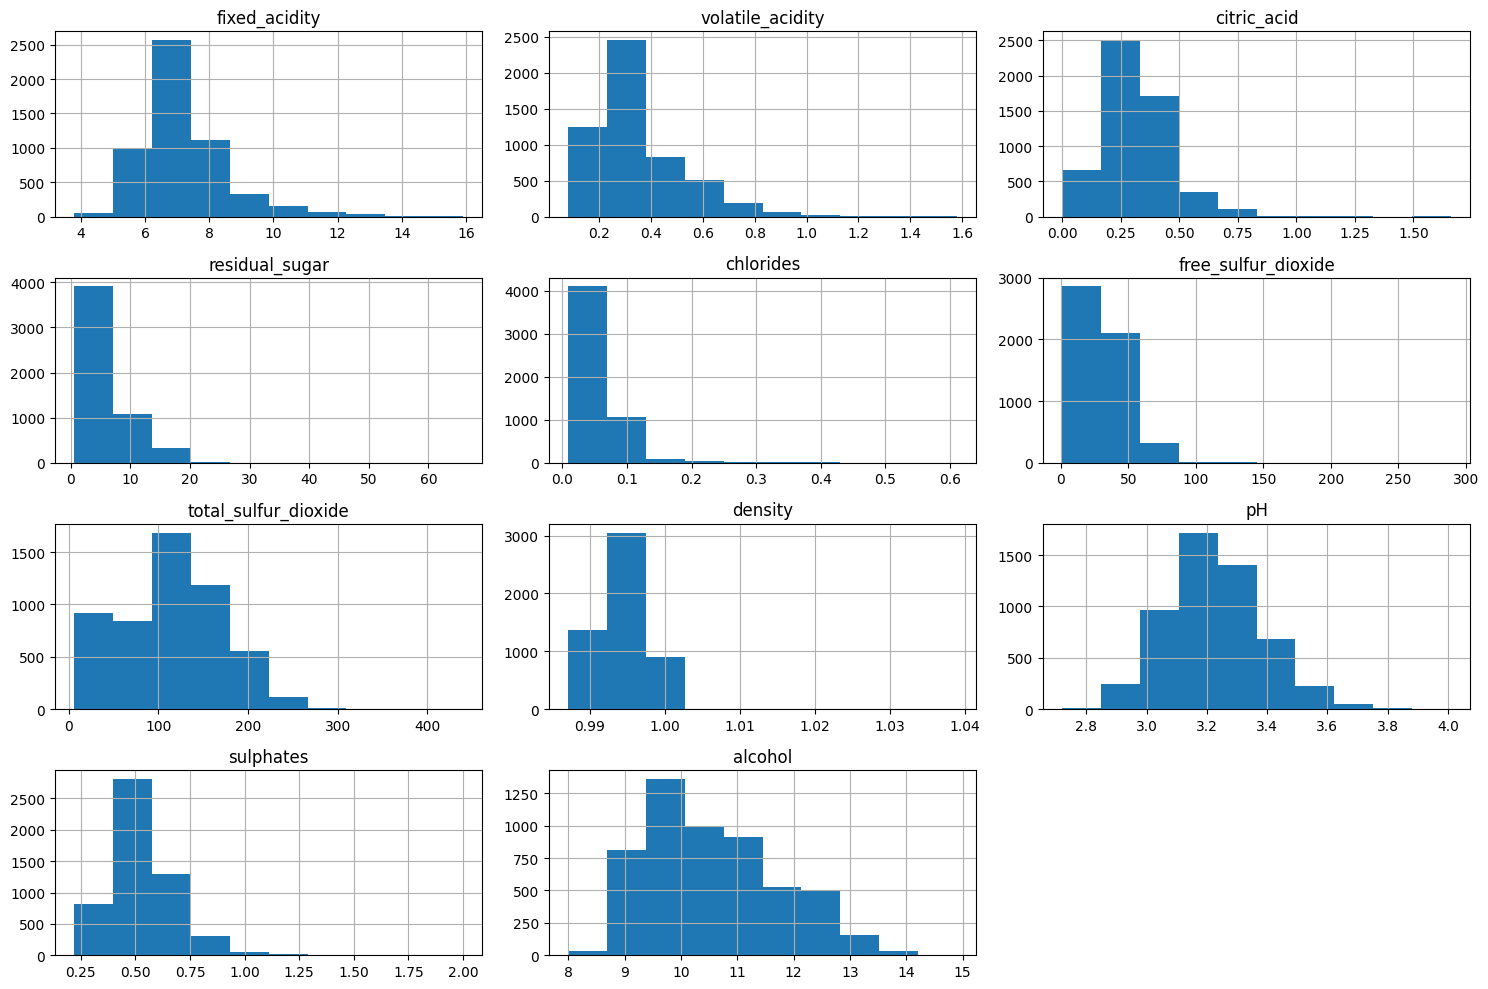

In [6]:
X.hist(figsize=(15,10))
plt.tight_layout()
plt.show()

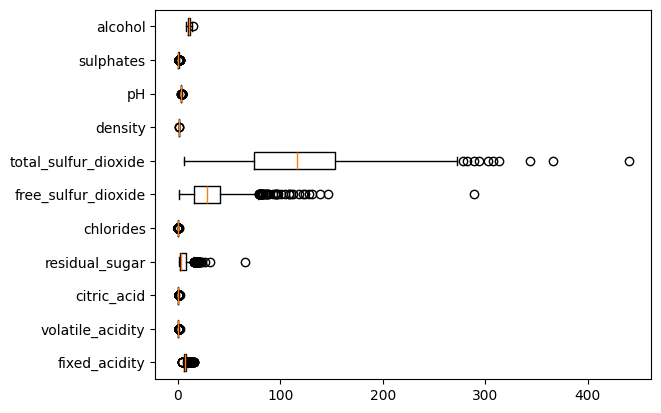

In [7]:
plt.boxplot(X.values, vert=False)
plt.yticks(range(1, X.shape[1] + 1), X.columns)
plt.show()

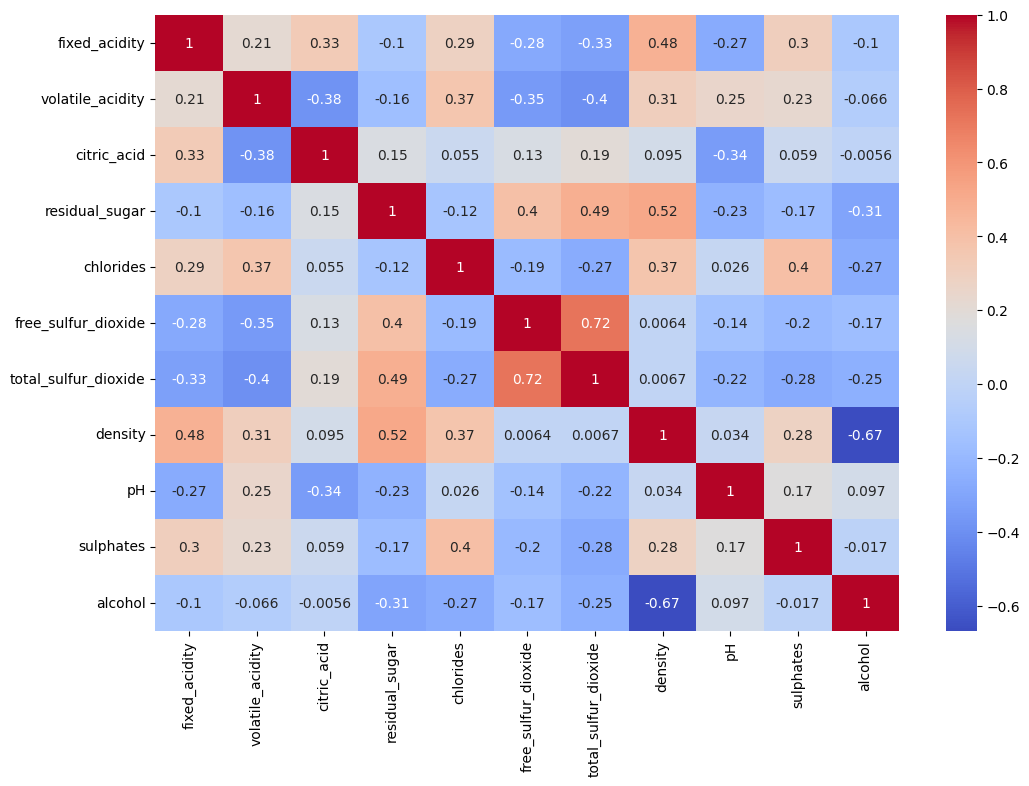

In [8]:
plt.figure(figsize=(12,8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.show()

#**Regressão**

In [9]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
pipe_s = Pipeline([ # RLS
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

pipe_m = Pipeline([ # RLM
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

pipe_p = Pipeline([ # RLP
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

In [11]:
def regression_report(y_true, y_pred, prefix=""):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    print(f"{prefix}\tR2={r2:.4f} | MAE={mae:.4f} | RMSE={rmse:.4f}")
    return {"R2": r2, "MAE": mae, "RMSE": rmse}

pipe_s.fit(X_train_r[['alcohol']], y_train_r)
pipe_m.fit(X_train_r, y_train_r)
pipe_p.fit(X_train_r[['alcohol']], y_train_r)

y_train_pred_s = pipe_s.predict(X_train_r[['alcohol']])
y_test_pred_s = pipe_s.predict(X_test_r[['alcohol']])
y_train_pred_m = pipe_m.predict(X_train_r)
y_test_pred_m = pipe_m.predict(X_test_r)
y_train_pred_p = pipe_p.predict(X_train_r[['alcohol']])
y_test_pred_p = pipe_p.predict(X_test_r[['alcohol']])

print("--- RLS ---")
regression_report(y_train_r, y_train_pred_s, prefix="Treino:")
regression_report(y_test_r, y_test_pred_s, prefix="Teste:")

print("\n--- RLM ---")
regression_report(y_train_r, y_train_pred_m, prefix="Treino:")
regression_report(y_test_r, y_test_pred_m, prefix="Teste:")

print("\n--- RLP ---")
regression_report(y_train_r, y_train_pred_p, prefix="Treino:")
regression_report(y_test_r, y_test_pred_p, prefix="Teste:")

--- RLS ---
Treino:	R2=0.2174 | MAE=0.6159 | RMSE=0.7810
Teste:	R2=0.2302 | MAE=0.5936 | RMSE=0.7599

--- RLM ---
Treino:	R2=0.3036 | MAE=0.5671 | RMSE=0.7367
Teste:	R2=0.3206 | MAE=0.5520 | RMSE=0.7139

--- RLP ---
Treino:	R2=0.2177 | MAE=0.6173 | RMSE=0.7808
Teste:	R2=0.2293 | MAE=0.5959 | RMSE=0.7604


{'R2': 0.2292700576299307,
 'MAE': 0.5959091219840498,
 'RMSE': 0.7603802799951533}

Os resultados de RLS e RLP são muito semelhantes, o que indica que os termos polinomiais não resultaram em melhora. Logo, a relação entre álcool e qualidade é aproximadamente linear.

As propriedades químicas explicam entre 21.74% e 32.06% da variação de qualidade segundo o resultado de R².

Os modelos são precisos, mas não perfeitos. RMSE é sempre maior que MAE, o que indica que há alguns erros extremos causados por outliers em álcool, e RLM tem a melhor diferença.

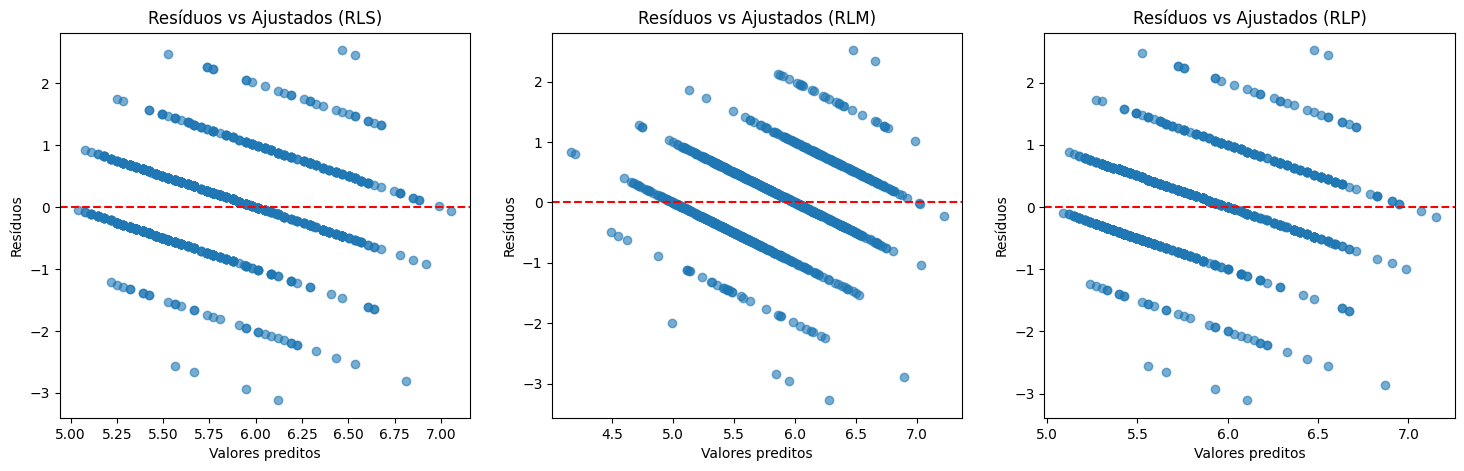

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

testes = [y_test_pred_s, y_test_pred_m, y_test_pred_p]
regressoes = ['RLS', 'RLM', 'RLP']

for i in range(len(testes)):
    residuos = y_test_r - testes[i]

    axes[i].scatter(testes[i], residuos, alpha=0.6)
    axes[i].axhline(0, color='red', linestyle='--')
    axes[i].set_xlabel('Valores preditos')
    axes[i].set_ylabel('Resíduos')
    axes[i].set_title(f'Resíduos vs Ajustados ({regressoes[i]})')

plt.show()

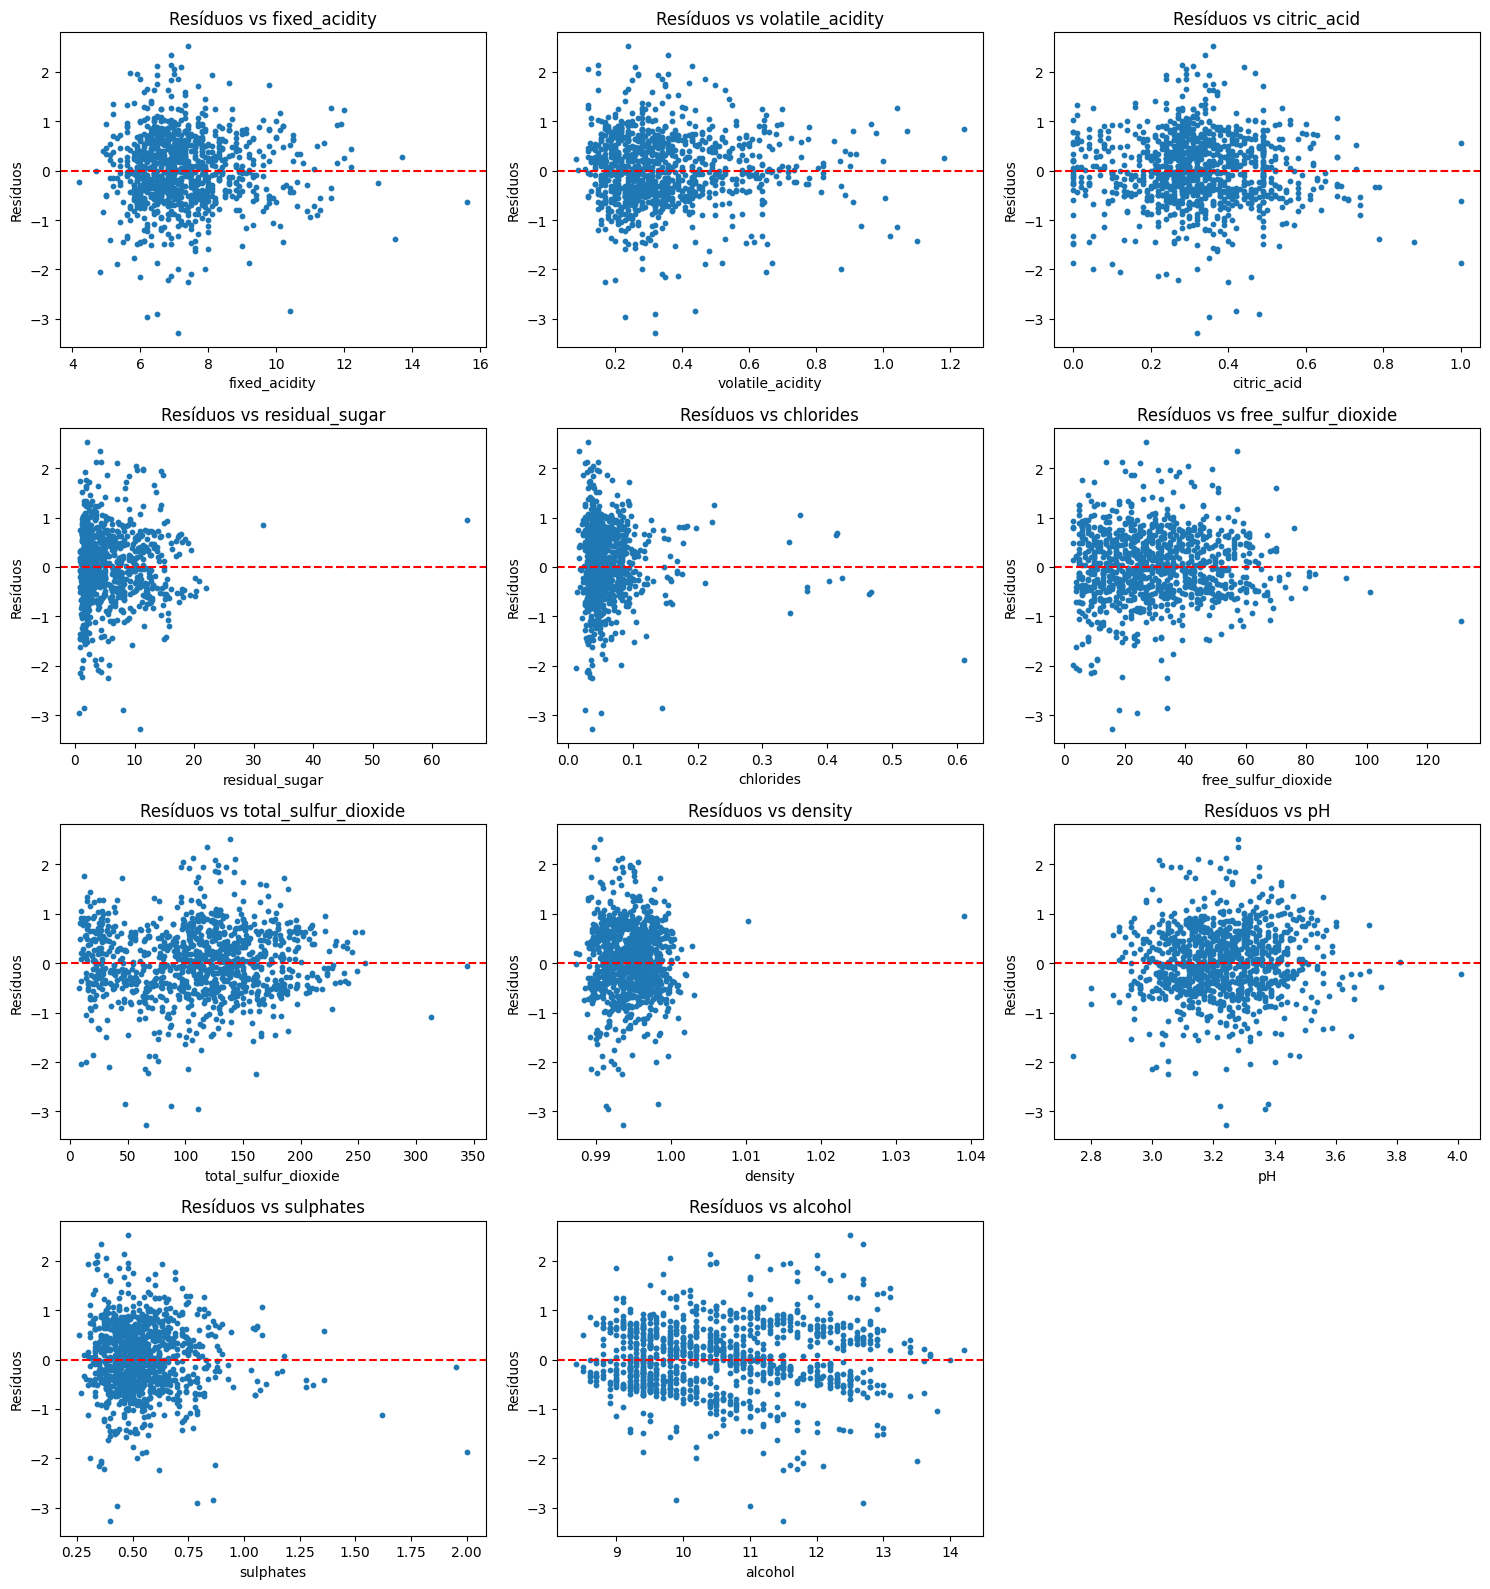

In [13]:
residuos = np.ravel(y_test_r - y_test_pred_m) # normal para RLM, segue o mesmo padrão em RLS e RLP porque usam só alcohol

cols = X_test_r.columns

fig, axes = plt.subplots(4, 3, figsize=(15, 16))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].scatter(X_test_r[col], residuos, s=10)
    axes[i].axhline(0, color="red", linestyle="--")
    axes[i].set_title(f"Resíduos vs {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Resíduos")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

O dataset tem heterocedasticidade, mas nenhuma coluna é responsável. Ela é causada pelo fato de que a varíavel-alvo tem poucos valores (3 a 9).

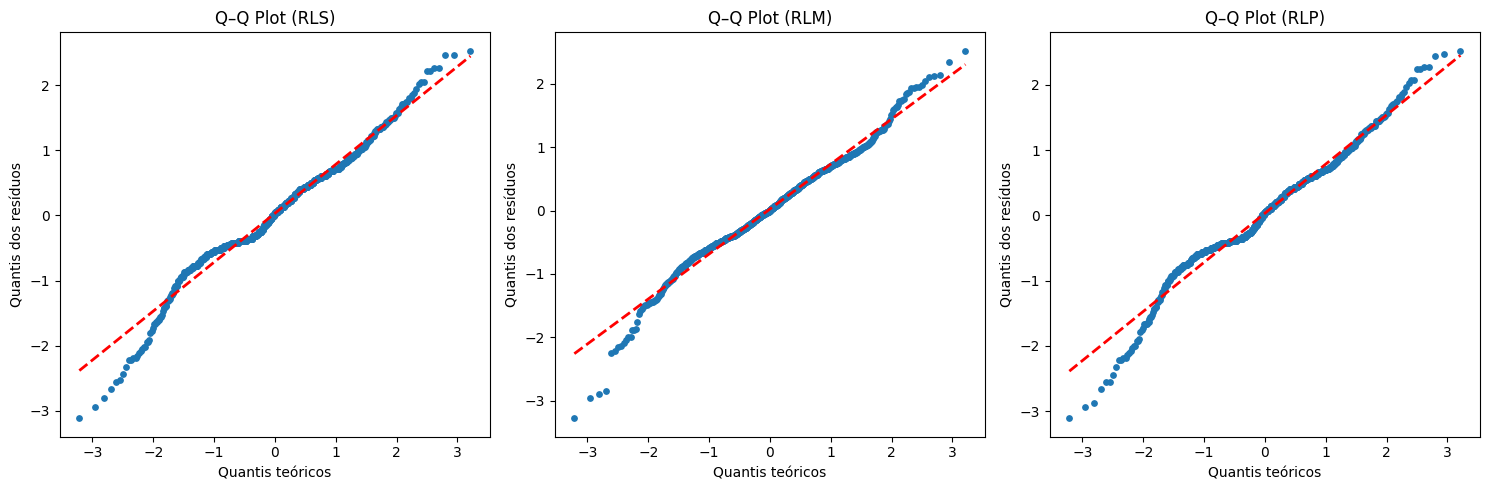

In [14]:
testes = [y_test_pred_s, y_test_pred_m, y_test_pred_p]
regressoes = ['RLS', 'RLM', 'RLP']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(testes)):
    residuos = np.ravel(y_test_r - testes[i])

    osm, osr = stats.probplot(residuos, dist="norm", fit=False)

    ax = axes[i]
    ax.scatter(osm, osr, s=15)

    slope, intercept = np.polyfit(osm, osr, 1)
    ax.plot(osm, slope * np.array(osm) + intercept, 'r--', lw=2)

    ax.set_title(f"Q–Q Plot ({regressoes[i]})")
    ax.set_xlabel("Quantis teóricos")
    ax.set_ylabel("Quantis dos resíduos")

plt.tight_layout()
plt.show()

Os resíduos não têm distribuição perfeitamente normal, com caudas mais pesadas e ondulação leve no meio, mas a maior parte dos pontos ainda segue a linha.

In [15]:
def compute_vif(df_features):
    X = sm.add_constant(df_features)
    vif = pd.Series(
        [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
        index=X.columns,
        name="VIF"
    )
    return vif

vif = compute_vif(X_train_r)
vif_df = vif.to_frame()
vif_df["VIF"] = vif_df["VIF"].map(lambda x: f"{x:,.4f}")
vif_df

,VIF
const,"1,927,360.7673"
fixed_acidity,5.3443
volatile_acidity,1.9728
citric_acid,1.6396
residual_sugar,6.6014
chlorides,1.6344
free_sulfur_dioxide,2.1250
total_sulfur_dioxide,2.9590
density,16.7203
pH,2.6788


Acidez fixa, açúcar residual e álcool têm VIF acima de 5, o que significa multicolinearidade moderada. Densidade tem VIF acima de 10, o que indica multicolinearidade muito alta.

*Seleção de Variáveis*

In [16]:
def remover_coluna(tipo_regressao='M', coluna=None, coluna_removida='density'):
  X_sd = X.drop(coluna_removida, axis=1)

  X_train_r_sd, X_test_r_sd, y_train_r_sd, y_test_r_sd = train_test_split(
      X_sd, y, test_size=0.2, random_state=42
  )

  elementos_pipeline = [("scaler", StandardScaler()), ("linreg", LinearRegression())]
  if tipo_regressao == 'P':
    elementos_pipeline.insert(0, ("poly", PolynomialFeatures(degree=2, include_bias=False)))

  pipe_sd = Pipeline(elementos_pipeline)

  X_train = X_train_r_sd[[coluna]] if tipo_regressao != 'M' else X_train_r_sd
  X_test = X_test_r_sd[[coluna]] if tipo_regressao != 'M' else X_test_r_sd

  pipe_sd.fit(X_train, y_train_r_sd)

  y_train_pred_sd = pipe_sd.predict(X_train)
  y_test_pred_sd = pipe_sd.predict(X_test)

  return X_train_r_sd, X_test_r_sd, y_train_r_sd, y_test_r_sd, y_train_pred_sd, y_test_pred_sd

*Interações Lineares*

In [17]:
def interacao_linear(tipo_regressao='M', coluna=None, coluna_1='alcohol', coluna_2='volatile_acidity'):
  X_train_r_inter = X_train_r.copy()
  X_test_r_inter = X_test_r.copy()

  X_train_r_inter[f"{coluna_1}_x_{coluna_2}"] = X_train_r[coluna_1] * X_train_r[coluna_2]
  X_test_r_inter[f"{coluna_1}_x_{coluna_2}"] = X_test_r[coluna_1] * X_test_r[coluna_2]

  elementos_pipeline = [("scaler", StandardScaler()), ("linreg", LinearRegression())]
  if tipo_regressao == 'P':
    elementos_pipeline.insert(0, ("poly", PolynomialFeatures(degree=2, include_bias=False)))

  pipe_inter = Pipeline(elementos_pipeline)

  X_train = X_train_r_inter[[coluna]] if tipo_regressao != 'M' else X_train_r_inter
  X_test = X_test_r_inter[[coluna]] if tipo_regressao != 'M' else X_test_r_inter

  pipe_inter.fit(X_train, y_train_r)

  y_train_pred_inter = pipe_inter.predict(X_train)
  y_test_pred_inter = pipe_inter.predict(X_test)

  return X_train_r_inter, X_test_r_inter, y_train_pred_inter, y_test_pred_inter

*Regularização*

In [18]:
def regularizacao_lasso(tipo_regressao='M', coluna=None):
  modelo_reg = LassoCV(cv=5, random_state=0)
  modelo_reg.fit(X_train_r, np.ravel(y_train_r))

  elementos_pipeline = [("scaler", StandardScaler()), ("linreg", LinearRegression())]
  if tipo_regressao == 'P':
    elementos_pipeline.insert(0, ("poly", PolynomialFeatures(degree=2, include_bias=False)))

  pipe_reg = Pipeline(elementos_pipeline)

  X_train = X_train_r[[coluna]] if tipo_regressao != 'M' else X_train_r
  X_test = X_test_r[[coluna]] if tipo_regressao != 'M' else X_test_r

  pipe_reg.fit(X_train, y_train_r)

  y_train_pred_reg = pipe_reg.predict(X_train)
  y_test_pred_reg = pipe_reg.predict(X_test)

  return y_train_pred_reg, y_test_pred_reg

*Tratamento de Outliers*

In [19]:
def tratamento_outliers(tipo_regressao='M', coluna=None):
  X_trat = X[(np.abs(stats.zscore(X)) < 3).all(axis=1)]
  y_trat = y.loc[X_trat.index]

  X_trat = X_trat.reset_index(drop=True)
  y_trat = y_trat.reset_index(drop=True)

  X_train_r_trat, X_test_r_trat, y_train_r_trat, y_test_r_trat = train_test_split(
      X_trat, y_trat, test_size=0.2, random_state=42
  )

  elementos_pipeline = [("scaler", StandardScaler()), ("linreg", LinearRegression())]
  if tipo_regressao == 'P':
    elementos_pipeline.insert(0, ("poly", PolynomialFeatures(degree=2, include_bias=False)))

  pipe_trat = Pipeline(elementos_pipeline)

  X_train = X_train_r_trat[[coluna]] if tipo_regressao != 'M' else X_train_r_trat
  X_test = X_test_r_trat[[coluna]] if tipo_regressao != 'M' else X_test_r_trat

  pipe_trat.fit(X_train, y_train_r_trat)

  y_train_pred_trat = pipe_trat.predict(X_train)
  y_test_pred_trat = pipe_trat.predict(X_test)

  return X_train_r_trat, X_test_r_trat, y_train_r_trat, y_test_r_trat, y_train_pred_trat, y_test_pred_trat

In [20]:
def dados_regressao(y_train, y_train_pred, y_test, y_test_pred):
  r2_train = r2_score(y_train, y_train_pred)
  mae_train = mean_absolute_error(y_train, y_train_pred)
  rmse_train = root_mean_squared_error(y_train, y_train_pred)

  r2_test = r2_score(y_test, y_test_pred)
  mae_test = mean_absolute_error(y_test, y_test_pred)
  rmse_test = root_mean_squared_error(y_test, y_test_pred)

  return {
    f"Treino R2": r2_train,
    f"Teste R2": r2_test,
    f"Treino MAE": mae_train,
    f"Teste MAE": mae_test,
    f"Treino RMSE": rmse_train,
    f"Teste RMSE": rmse_test
  }

In [21]:
X_train_r_sd, X_test_r_sd, y_train_r_sd, y_test_r_sd, y_train_pred_sd_s, y_test_pred_sd_s = remover_coluna(tipo_regressao='S', coluna='alcohol')
_, _, _, _, y_train_pred_sd_m, y_test_pred_sd_m = remover_coluna(tipo_regressao='M')
_, _, _, _, y_train_pred_sd_p, y_test_pred_sd_p = remover_coluna(tipo_regressao='P', coluna='alcohol')

X_train_r_inter, X_test_r_inter, y_train_pred_inter_s, y_test_pred_inter_s = interacao_linear(tipo_regressao='S', coluna='alcohol')
_, _, y_train_pred_inter_m, y_test_pred_inter_m = interacao_linear(tipo_regressao='M')
_, _, y_train_pred_inter_p, y_test_pred_inter_p = interacao_linear(tipo_regressao='P', coluna='alcohol')

y_train_pred_reg_s, y_test_pred_reg_s = regularizacao_lasso(tipo_regressao='S', coluna='alcohol')
y_train_pred_reg_m, y_test_pred_reg_m = regularizacao_lasso(tipo_regressao='M')
y_train_pred_reg_p, y_test_pred_reg_p = regularizacao_lasso(tipo_regressao='P', coluna='alcohol')

X_train_r_trat, X_test_r_trat, y_train_r_trat, y_test_r_trat, y_train_pred_trat_s, y_test_pred_trat_s = tratamento_outliers(tipo_regressao='S', coluna='alcohol')
_, _, _, _, y_train_pred_trat_m, y_test_pred_trat_m = tratamento_outliers(tipo_regressao='M')
_, _, _, _, y_train_pred_trat_p, y_test_pred_trat_p = tratamento_outliers(tipo_regressao='P', coluna='alcohol')

In [22]:
padrao_dados_s = dados_regressao(y_train_r, y_train_pred_s, y_test_r, y_test_pred_s)
padrao_dados_m = dados_regressao(y_train_r, y_train_pred_m, y_test_r, y_test_pred_m)
padrao_dados_p = dados_regressao(y_train_r, y_train_pred_p, y_test_r, y_test_pred_p)

sem_densidade_dados_s = dados_regressao(y_train_r_sd, y_train_pred_sd_s, y_test_r_sd, y_test_pred_sd_s)
sem_densidade_dados_m = dados_regressao(y_train_r_sd, y_train_pred_sd_m, y_test_r_sd, y_test_pred_sd_m)
sem_densidade_dados_p = dados_regressao(y_train_r_sd, y_train_pred_sd_p, y_test_r_sd, y_test_pred_sd_p)

interacao_linear_dados_s = dados_regressao(y_train_r, y_train_pred_inter_s, y_test_r, y_test_pred_inter_s)
interacao_linear_dados_m = dados_regressao(y_train_r, y_train_pred_inter_m, y_test_r, y_test_pred_inter_m)
interacao_linear_dados_p = dados_regressao(y_train_r, y_train_pred_inter_p, y_test_r, y_test_pred_inter_p)

regularizado_dados_s = dados_regressao(y_train_r, y_train_pred_reg_s, y_test_r, y_test_pred_reg_s)
regularizado_dados_m = dados_regressao(y_train_r, y_train_pred_reg_m, y_test_r, y_test_pred_reg_m)
regularizado_dados_p = dados_regressao(y_train_r, y_train_pred_reg_p, y_test_r, y_test_pred_reg_p)

tratamento_outliers_dados_s = dados_regressao(y_train_r_trat, y_train_pred_trat_s, y_test_r_trat, y_test_pred_trat_s)
tratamento_outliers_dados_m = dados_regressao(y_train_r_trat, y_train_pred_trat_m, y_test_r_trat, y_test_pred_trat_m)
tratamento_outliers_dados_p = dados_regressao(y_train_r_trat, y_train_pred_trat_p, y_test_r_trat, y_test_pred_trat_p)


df_comp_r = pd.DataFrame([
    {'Otimização': 'Nenhuma', 'Tipo Regressão': 'Simples', **padrao_dados_s},
    {'Otimização': 'Nenhuma', 'Tipo Regressão': 'Múltipla', **padrao_dados_m},
    {'Otimização': 'Nenhuma', 'Tipo Regressão': 'Polinomial', **padrao_dados_p},
    {'Otimização': 'Densidade Removida', 'Tipo Regressão': 'Simples', **sem_densidade_dados_s},
    {'Otimização': 'Densidade Removida', 'Tipo Regressão': 'Múltipla', **sem_densidade_dados_m},
    {'Otimização': 'Densidade Removida', 'Tipo Regressão': 'Polinomial', **sem_densidade_dados_p},
    {'Otimização': 'Coluna Álcool x Acidez', 'Tipo Regressão': 'Simples', **interacao_linear_dados_s},
    {'Otimização': 'Coluna Álcool x Acidez', 'Tipo Regressão': 'Múltipla', **interacao_linear_dados_m},
    {'Otimização': 'Coluna Álcool x Acidez', 'Tipo Regressão': 'Polinomial', **interacao_linear_dados_p},
    {'Otimização': 'Regularização LassoCV', 'Tipo Regressão': 'Simples', **regularizado_dados_s},
    {'Otimização': 'Regularização LassoCV', 'Tipo Regressão': 'Múltipla', **regularizado_dados_m},
    {'Otimização': 'Regularização LassoCV', 'Tipo Regressão': 'Polinomial', **regularizado_dados_p},
    {'Otimização': 'Tratamento de Outliers', 'Tipo Regressão': 'Simples', **tratamento_outliers_dados_s},
    {'Otimização': 'Tratamento de Outliers', 'Tipo Regressão': 'Múltipla', **tratamento_outliers_dados_m},
    {'Otimização': 'Tratamento de Outliers', 'Tipo Regressão': 'Polinomial', **tratamento_outliers_dados_p},
])

df_comp_r

,Otimização,Tipo Regressão,Treino R2,Teste R2,Treino MAE,Teste MAE,Treino RMSE,Teste RMSE
0,Nenhuma,Simples,0.217368,0.230199,0.615895,0.593648,0.780985,0.759922
1,Nenhuma,Múltipla,0.303584,0.320618,0.567143,0.552037,0.736713,0.713899
2,Nenhuma,Polinomial,0.217672,0.229270,0.617272,0.595909,0.780833,0.760380
3,Densidade Removida,Simples,0.217368,0.230199,0.615895,0.593648,0.780985,0.759922
4,Densidade Removida,Múltipla,0.301278,0.317760,0.568911,0.552585,0.737932,0.715399
5,Densidade Removida,Polinomial,0.217672,0.229270,0.617272,0.595909,0.780833,0.760380
6,Coluna Álcool x Acidez,Simples,0.217368,0.230199,0.615895,0.593648,0.780985,0.759922
7,Coluna Álcool x Acidez,Múltipla,0.303678,0.319603,0.566981,0.552022,0.736663,0.714432
8,Coluna Álcool x Acidez,Polinomial,0.217672,0.229270,0.617272,0.595909,0.780833,0.760380
9,Regularização LassoCV,Simples,0.217368,0.230199,0.615895,0.593648,0.780985,0.759922


Densidade removida ajuda na multicolinearidade, mas não nas métricas analisadas, com cada uma se tornando ligeiramente pior. Isso quer dizer que a multicolinearidade não estava afetando a capacidade do modelo de prever a qualidade.

Tratamento de outliers é o único modelo otimizado no qual os valores de RLS e RLP são diferentes do modelo padrão, já que é o único no qual os valores da coluna de álcool são modificados. Os resultados do modelo em geral são mistos, com melhoras leves em todos exceto o MAE e RMSE de teste.

Os modelos não impactaram as métricas significativamente. O modelo não sofria problemas de complexidade ou estabilidade.

In [23]:
def plot_residuos_vs_ajustados(ax, cm, titulo):
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(titulo)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])

    ax.set_xticklabels(['Bom', 'Ruim'])
    ax.set_yticklabels(['Bom', 'Ruim'])

    ax.set_xlabel('Previsto')
    ax.set_ylabel('Real')

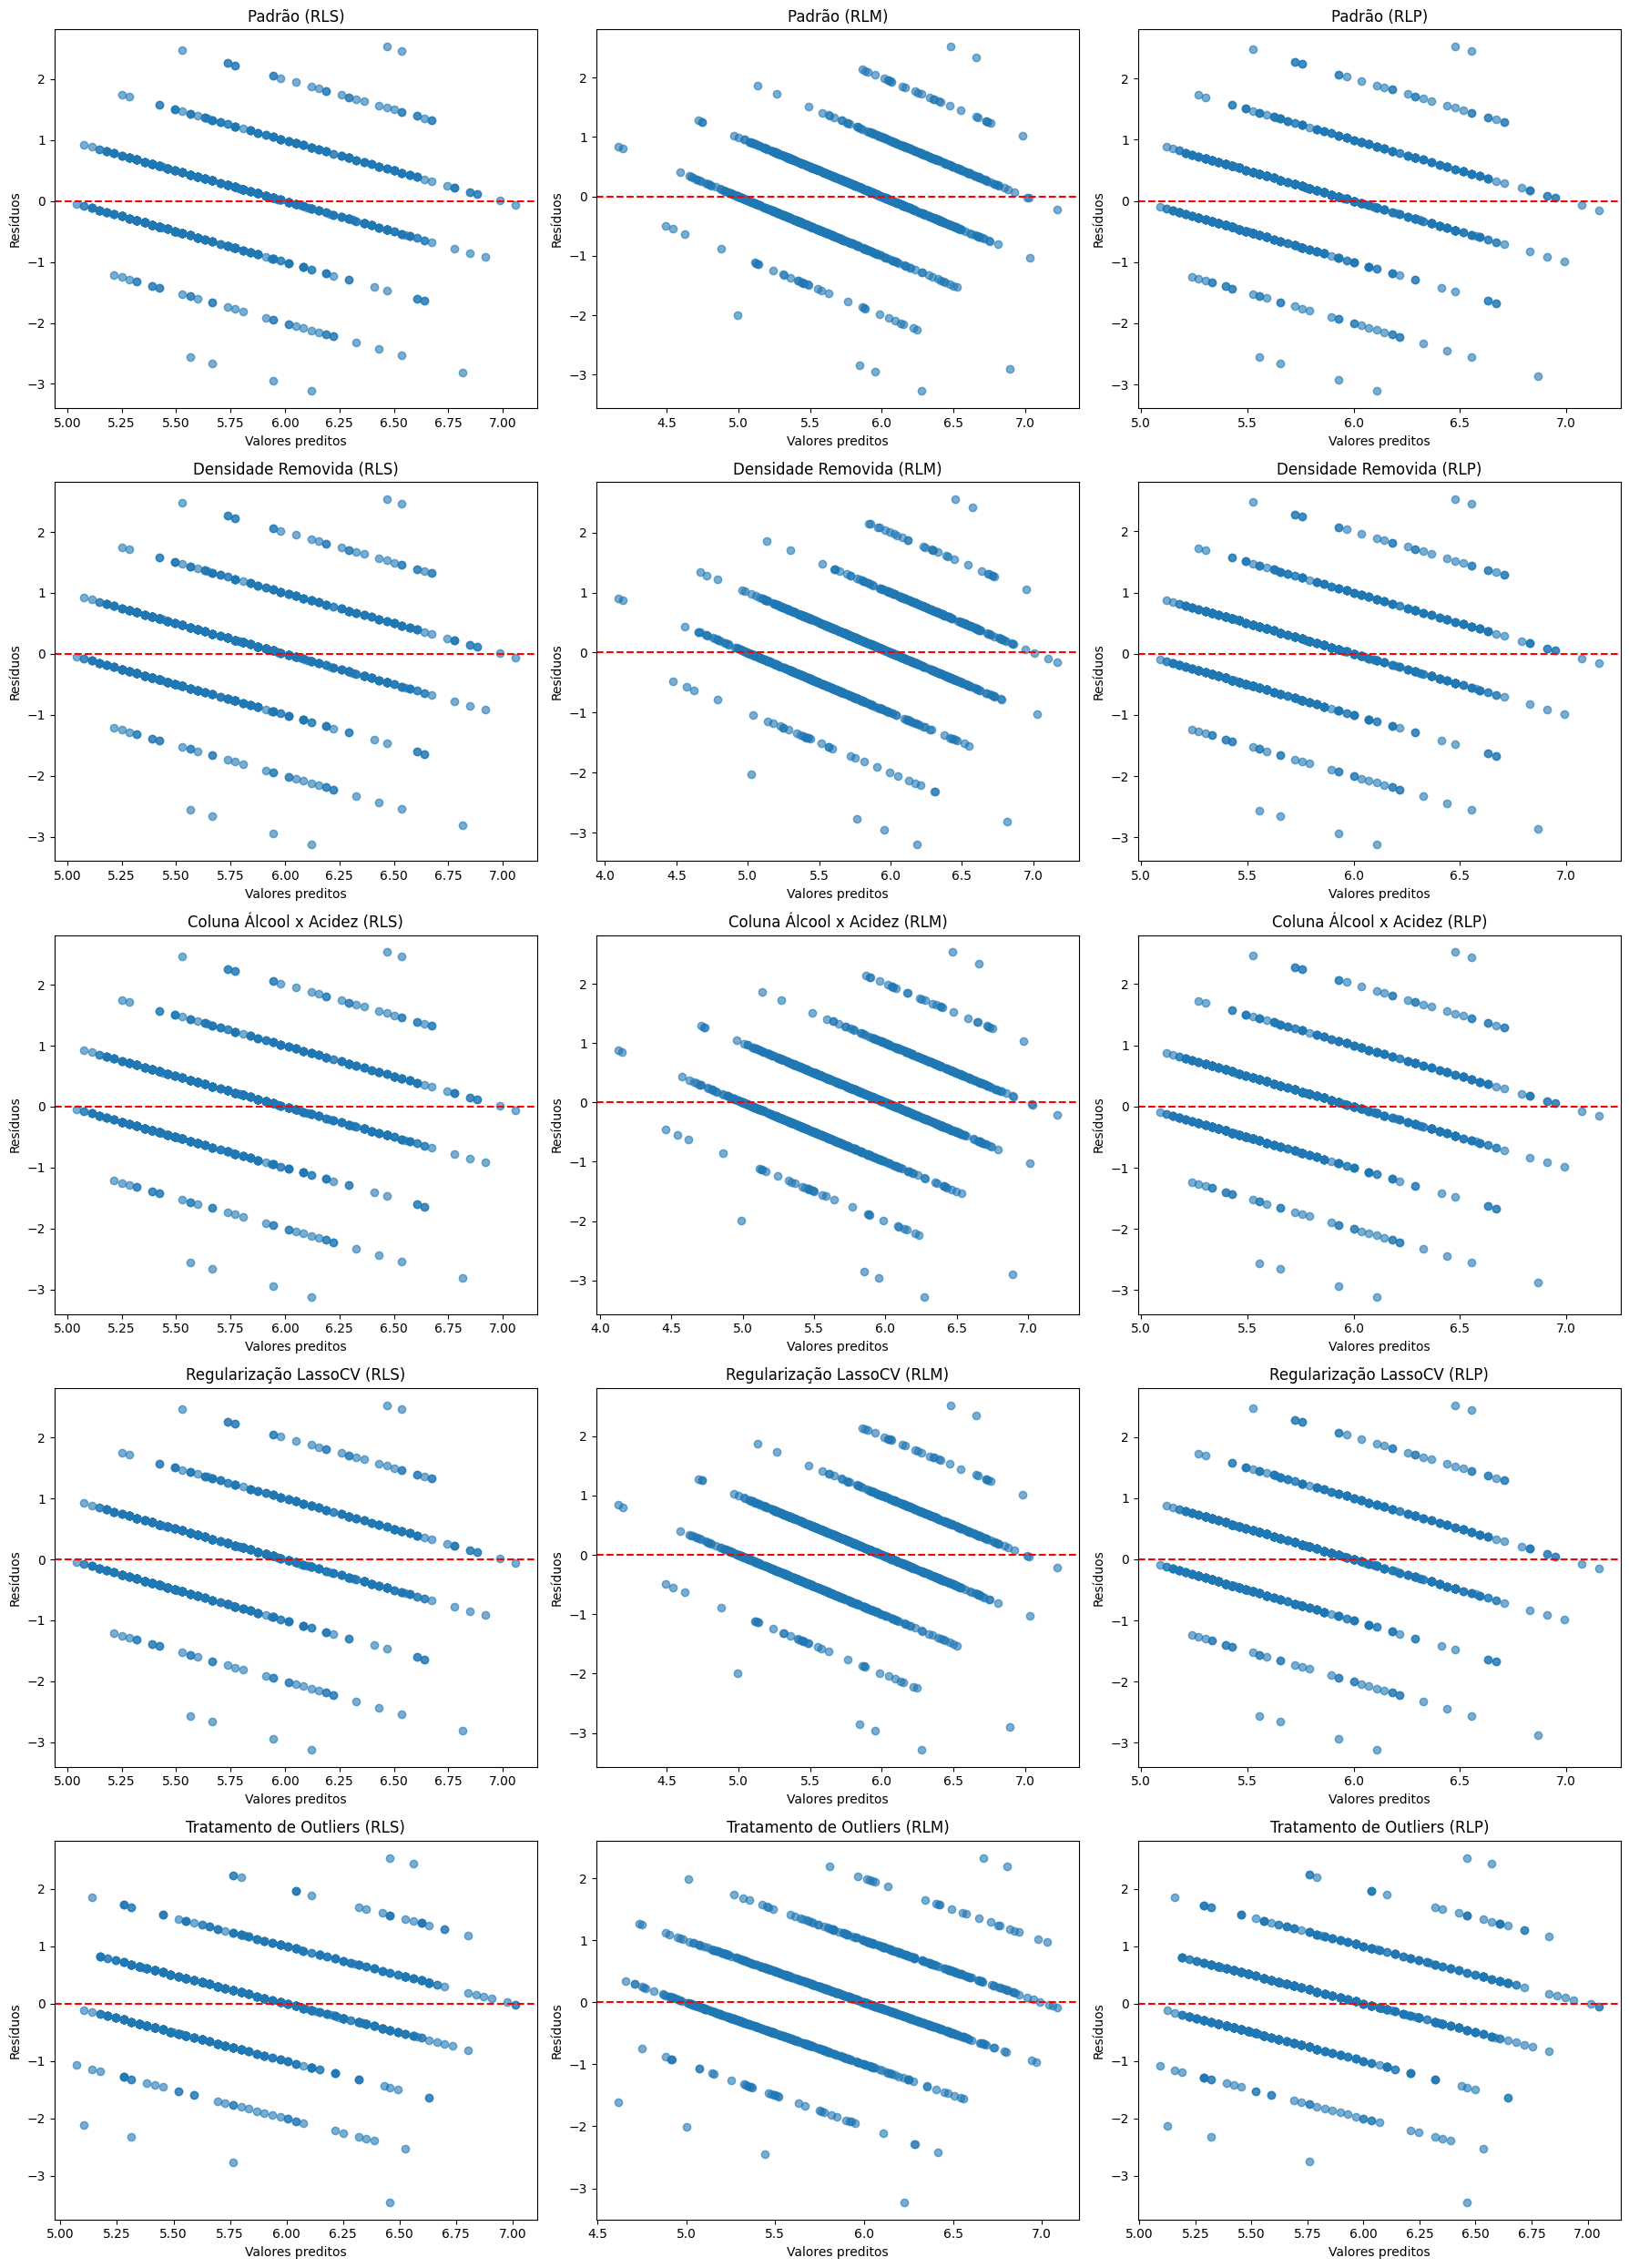

In [24]:
fig, axes = plt.subplots(5, 3, figsize=(18, 25))

testes_previsoes = [
  [y_test_pred_s, y_test_pred_m, y_test_pred_p],
  [y_test_pred_sd_s, y_test_pred_sd_m, y_test_pred_sd_p],
  [y_test_pred_inter_s, y_test_pred_inter_m, y_test_pred_inter_p],
  [y_test_pred_reg_s, y_test_pred_reg_m, y_test_pred_reg_p],
  [y_test_pred_trat_s, y_test_pred_trat_m, y_test_pred_trat_p],
]
testes = [y_test_r, y_test_r_sd, y_test_r, y_test_r, y_test_r_trat]
otimizacoes = ['Padrão', 'Densidade Removida', 'Coluna Álcool x Acidez', 'Regularização LassoCV', 'Tratamento de Outliers']
regressoes = ['RLS', 'RLM', 'RLP']

for i in range(len(testes_previsoes)):
  for j in range(len(testes_previsoes[i])):
      residuos = testes[i] - testes_previsoes[i][j]

      ax = axes[i,j]

      ax.scatter(testes_previsoes[i][j], residuos, alpha=0.6)
      ax.axhline(0, color='red', linestyle='--')
      ax.set_xlabel('Valores preditos')
      ax.set_ylabel('Resíduos')
      ax.set_title(f'{otimizacoes[i]} ({regressoes[j]})')

plt.tight_layout()
plt.show()

Os modelos diferentes não alteraram a heterocedasticidade, evidenciando que esta é causada pela estrutura da variável-alvo e não pelo modelo.

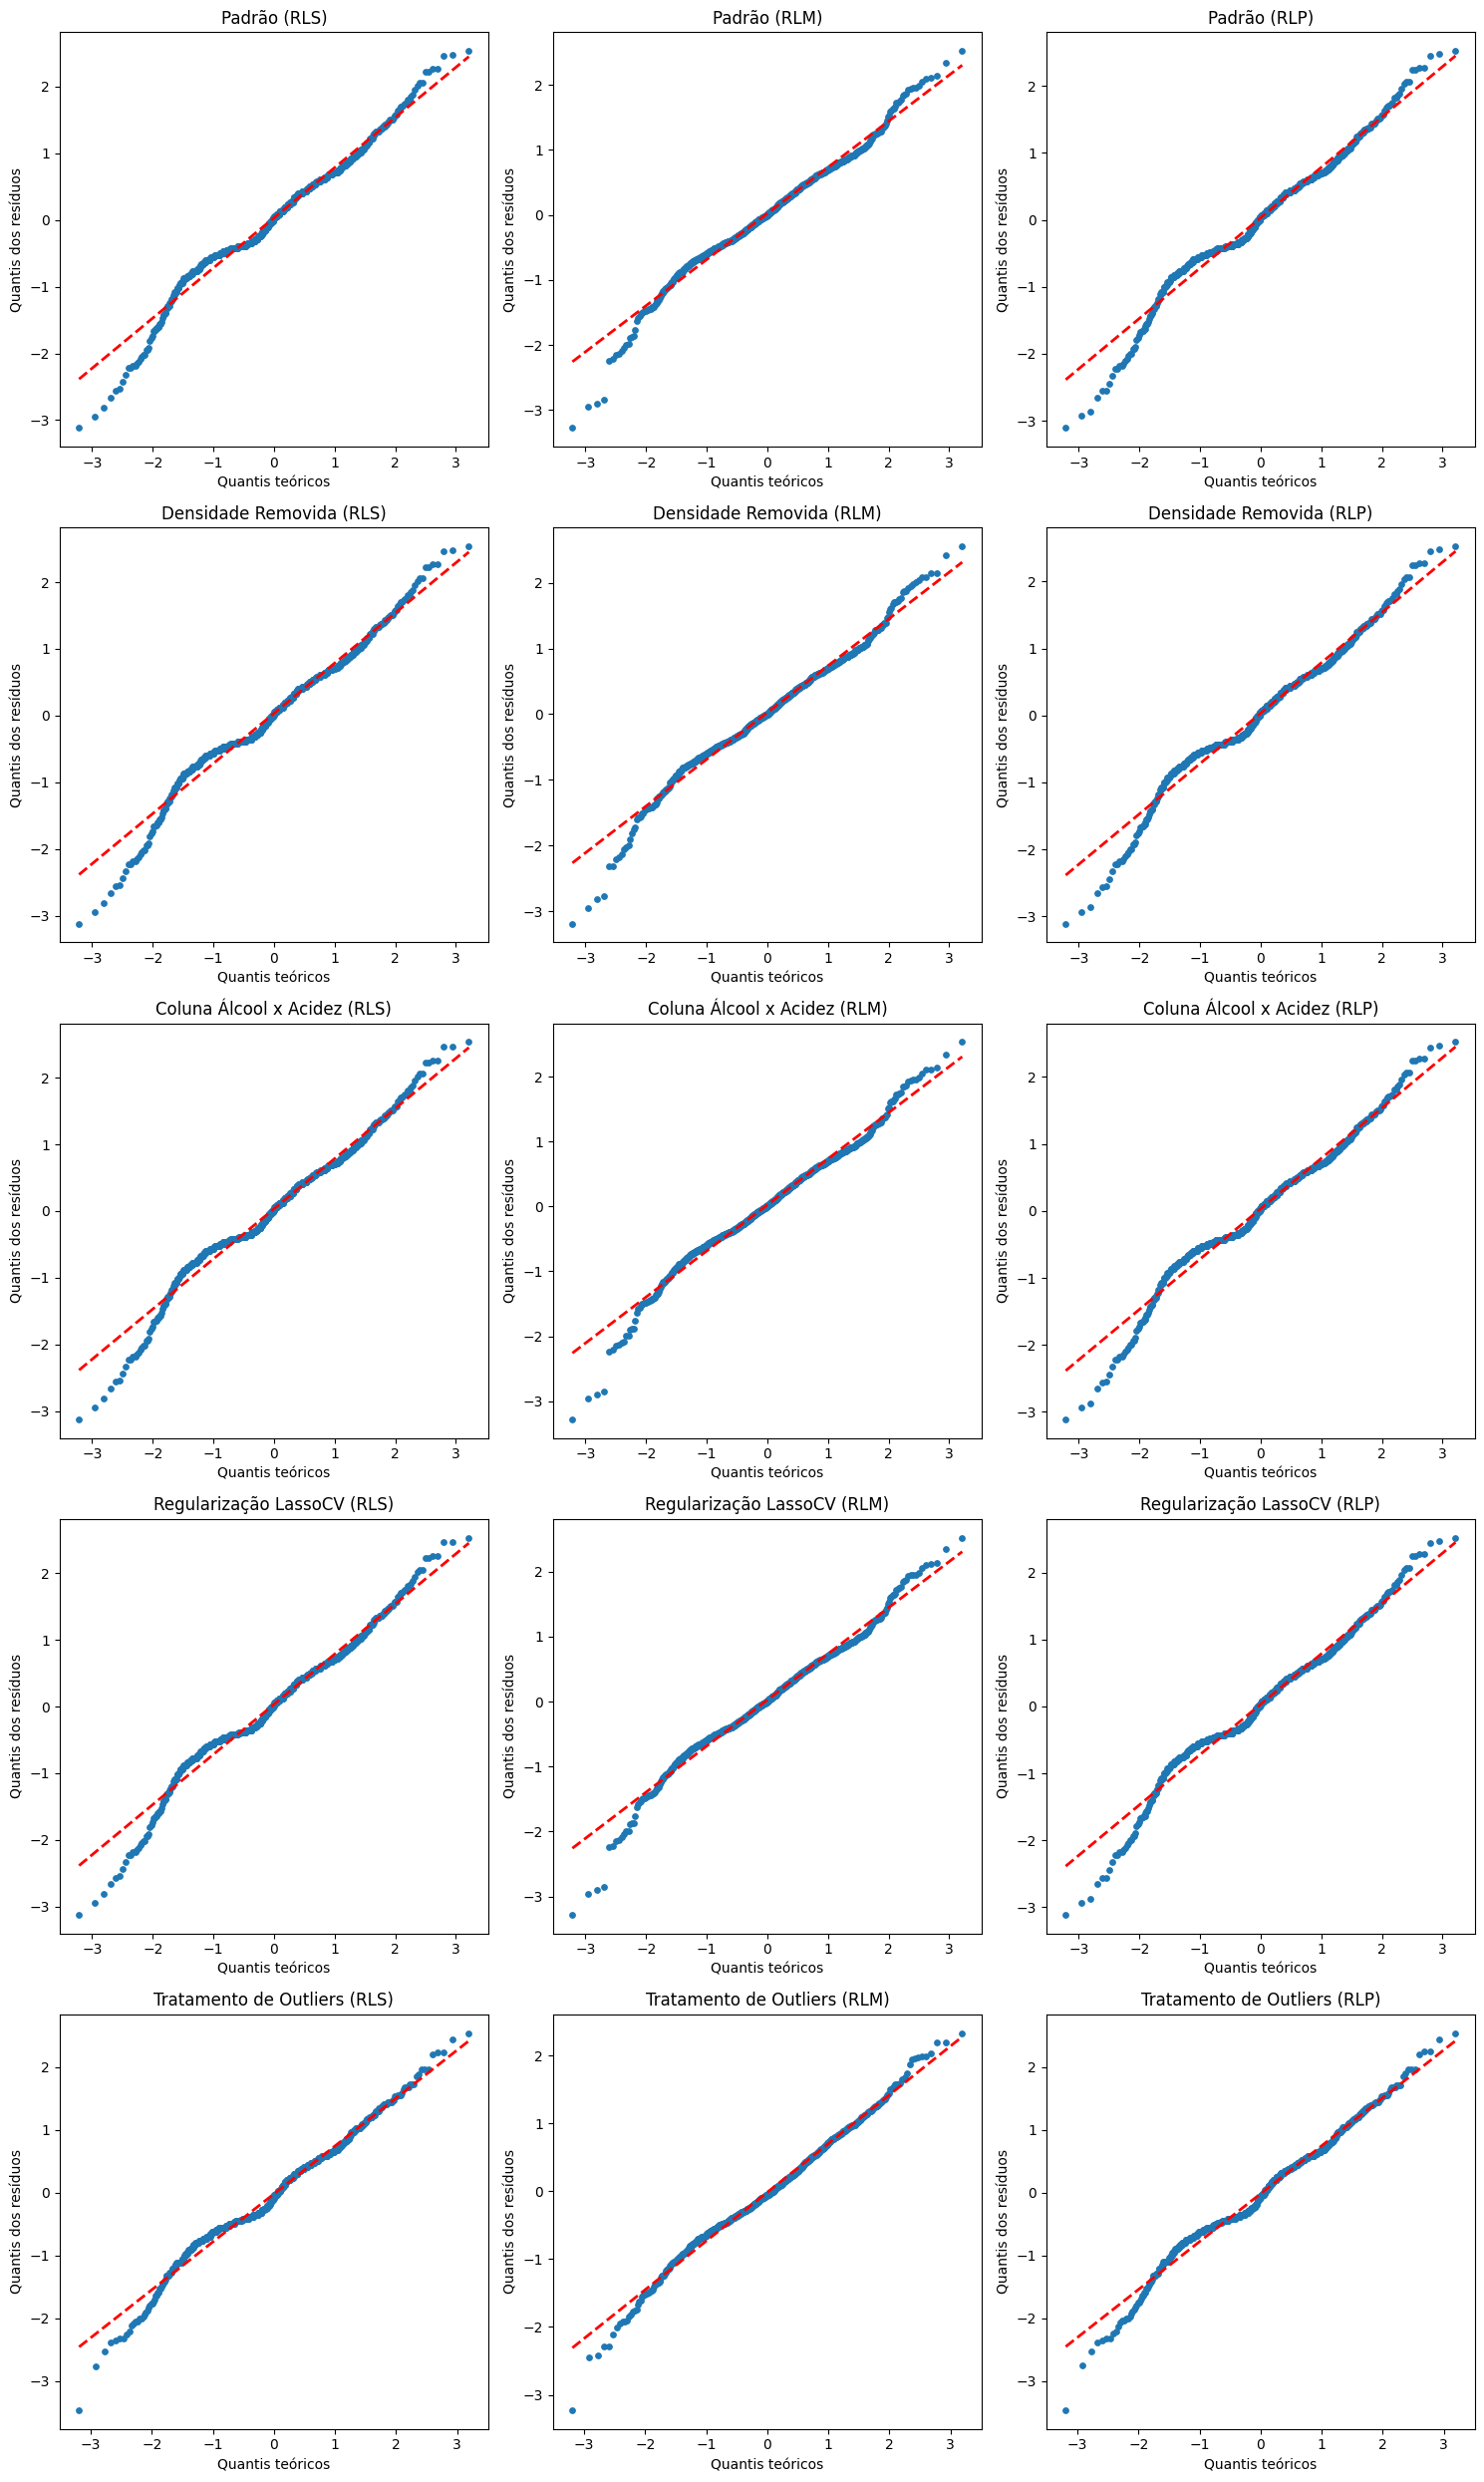

In [25]:
fig, axes = plt.subplots(5, 3, figsize=(15, 25))

testes_previsoes = [
  [y_test_pred_s, y_test_pred_m, y_test_pred_p],
  [y_test_pred_sd_s, y_test_pred_sd_m, y_test_pred_sd_p],
  [y_test_pred_inter_s, y_test_pred_inter_m, y_test_pred_inter_p],
  [y_test_pred_reg_s, y_test_pred_reg_m, y_test_pred_reg_p],
  [y_test_pred_trat_s, y_test_pred_trat_m, y_test_pred_trat_p],
]
testes = [y_test_r, y_test_r_sd, y_test_r, y_test_r, y_test_r_trat]
otimizacoes = ['Padrão', 'Densidade Removida', 'Coluna Álcool x Acidez', 'Regularização LassoCV', 'Tratamento de Outliers']
regressoes = ['RLS', 'RLM', 'RLP']

for i in range(len(testes_previsoes)):
  for j in range(len(testes_previsoes[i])):
    residuos = np.ravel(testes[i] - testes_previsoes[i][j])

    osm, osr = stats.probplot(residuos, dist="norm", fit=False)

    ax = axes[i,j]
    ax.scatter(osm, osr, s=15)

    slope, intercept = np.polyfit(osm, osr, 1)
    ax.plot(osm, slope * np.array(osm) + intercept, 'r--', lw=2)

    ax.set_title(f"{otimizacoes[i]} ({regressoes[j]})")
    ax.set_xlabel("Quantis teóricos")
    ax.set_ylabel("Quantis dos resíduos")

plt.tight_layout()
plt.show()

A maioria dos modelos não afetou os gráficos Q-Q, com exceção do tratamento de outliers, que reduziu a ondulação e o peso das caudas de modo mais perceptível, deixando a distribuição dos dados mais normal.

In [26]:
treinos = [X_train_r, X_train_r_sd, X_train_r_inter, X_train_r, X_train_r_trat]
otimizacoes = ['Padrão', 'Densidade Removida', 'Coluna Álcool x Acidez', 'Regularização LassoCV', 'Tratamento de Outliers']

vif = pd.DataFrame()

for i in range(len(otimizacoes)):
  vif_valor = compute_vif(treinos[i])
  vif_df = vif_valor.to_frame()
  vif = vif.reindex(vif.index.union(vif_df.index))
  vif[otimizacoes[i]] = vif_df["VIF"]

vif = vif.map(lambda x: f"{x:,.4f}" if pd.notnull(x) else "")
vif = pd.concat([
    vif.loc[['const']],
    vif.drop(index='const')
])

vif

,Padrão,Densidade Removida,Coluna Álcool x Acidez,Regularização LassoCV,Tratamento de Outliers
const,"1,927,360.7673",908.4160,"1,955,684.3107","1,927,360.7673","2,364,666.1508"
alcohol,5.2328,1.3710,12.5994,5.2328,5.9216
alcohol_x_volatile_acidity,,,110.1776,,
chlorides,1.6344,1.5487,1.6432,1.6344,2.2595
citric_acid,1.6396,1.6395,1.6397,1.6396,1.5879
density,16.7203,,16.8993,16.7203,19.2839
fixed_acidity,5.3443,1.8167,5.3840,5.3443,4.2639
free_sulfur_dioxide,2.1250,2.1222,2.1263,2.1250,2.1391
pH,2.6788,1.4199,2.6789,2.6788,2.5983
residual_sugar,6.6014,1.4509,6.6015,6.6014,7.4426


Multicolinearidade é mais afetada pelos modelos diferentes.

Remover a densidade conserta o problema de multicolinearidade, com nenhum VIF chegando a 3 ou mais.<br>
Criar a coluna de álcool x acidez causou um grande aumento na multicolinearidade das colunas combinadas e da coluna nova, com os VIFs da acidez e da coluna combinada superando 100 e o de álcool subindo para 12.<br>
A regularização LassoCV não mudou os valores de VIF, já que não altera os dados e simplemente cria um modelo diferente.<br>
O tratamento de outliers causou mudanças no VIF distintas para cada coluna, pois cada uma tem uma quantidade diferente de outliers removidos que podem impactar positivamente ou negativamente a correlação com as demais.

#**Classificação**

https://cdn.winespectator.com/articles/scoring-scale
https://www.wine.com/content/landing/ratingsexplained

Segundo a pesquisa, um vinho é considerado bom quanto tem a partir de 80 pontos. No dataset, isso equivale a uma qualidade de 8 e acima.

In [27]:
y_bin = (y > 7).astype(int)

X_train_c, X_temp_c, y_train_c, y_temp_c = train_test_split(
    X, y_bin, test_size=0.2, random_state=42
)
X_test_c, X_val_c, y_test_c, y_val_c = train_test_split(
    X_temp_c, y_temp_c, test_size=0.5, random_state=42
)

y_train_c = y_train_c.iloc[:, 0] # transforma em série porque não aceita DataFrame

baseline = np.full_like(y_test_c, fill_value=y_train_c.mode().iloc[0])

##Naive Bayes

In [28]:
modelo = GaussianNB()
modelo.fit(X_train_c, y_train_c)

y_pred_nb = modelo.predict(X_val_c)
y_prob_nb = modelo.predict_proba(X_val_c)[:, 1]

test_pred_nb = modelo.predict(X_test_c)
test_prob_nb = modelo.predict_proba(X_test_c)[:, 1]

cm_nb = confusion_matrix(y_test_c, test_pred_nb, labels=[1, 0])

*Ajuste de Limiares por Youden J*

In [29]:
fpr, tpr, thr = roc_curve(y_val_c, y_prob_nb)

youden_j = tpr - fpr
indice = np.argmax(youden_j)
limiar_nb_yj = thr[indice]

print("Limiar:", limiar_nb_yj)

y_pred_nb_yj = (y_prob_nb >= limiar_nb_yj).astype(int)
test_pred_nb_yj = (test_prob_nb >= limiar_nb_yj).astype(int)

cm_nb_yj = confusion_matrix(y_test_c, test_pred_nb_yj, labels=[1, 0])

Limiar: 0.11934307274049072


*Ajuste de Limiares por F1-score*

In [30]:
limiares = np.linspace(0, 1, 101)
f1_scores = []

for t in limiares:
    y_pred_f1 = (y_prob_nb >= t).astype(int)
    f1 = f1_score(y_val_c, y_pred_f1)
    f1_scores.append(f1)

melhor_indice = np.argmax(f1_scores)
limiar_nb_f1 = limiares[melhor_indice]

print("Melhor threshold pelo F1-score:", limiar_nb_f1)
print("F1-score correspondente:", f1_scores[melhor_indice])

y_pred_nb_f1 = (y_prob_nb >= limiar_nb_f1).astype(int)
test_pred_nb_f1 = (test_prob_nb >= limiar_nb_f1).astype(int)

cm_nb_f1 = confusion_matrix(y_test_c, test_pred_nb_f1, labels=[1, 0])

Melhor threshold pelo F1-score: 0.5700000000000001
F1-score correspondente: 0.2033898305084746


*Ajuste de var_smoothing manual*

In [31]:
faixa = np.logspace(-12, -6, 20)

melhor_recall = -1
melhor_vs = None

for vs in faixa:
    model = GaussianNB(var_smoothing=vs)
    model.fit(X_train_c, y_train_c)

    prob = model.predict_proba(X_val_c)[:,1]
    pred = (prob >= 0.5).astype(int)

    rec = recall_score(y_val_c, pred)

    if rec > melhor_recall:
        melhor_recall = rec
        melhor_vs = vs

print(f"Melhor var_smoothing: {melhor_vs} (recall {melhor_recall})")

modelo_vs = GaussianNB(var_smoothing=melhor_vs)
modelo_vs.fit(X_train_c, y_train_c)

y_prob_vs = modelo_vs.predict_proba(X_val_c)[:, 1]
y_pred_vs = modelo_vs.predict(X_val_c)

test_prob_vs = modelo_vs.predict_proba(X_test_c)[:, 1]
test_pred_vs = modelo_vs.predict(X_test_c)

cm_nb_vs = confusion_matrix(y_test_c, test_pred_vs, labels=[1, 0])

Melhor var_smoothing: 1e-12 (recall 0.5384615384615384)


*Ajuste de var_smoothing por Grid Search*

In [32]:
param_grid = {
    "var_smoothing": np.logspace(-12, -6, 20)
}

grid = GridSearchCV(
    GaussianNB(),
    param_grid,
    scoring="recall",
    cv=5
)

grid.fit(X_train_c, y_train_c)

print("Melhor var_smoothing:", grid.best_params_['var_smoothing'])
print("Melhor score:", grid.best_score_)

modelo_vs_grid = grid.best_estimator_

y_prob_vs_grid = modelo_vs_grid.predict_proba(X_val_c)[:, 1]
y_pred_vs_grid = modelo_vs_grid.predict(X_val_c)

test_prob_vs_grid = modelo_vs_grid.predict_proba(X_test_c)[:, 1]
test_pred_vs_grid = modelo_vs_grid.predict(X_test_c)

cm_nb_vs_grid = confusion_matrix(y_test_c, test_pred_vs_grid, labels=[1, 0])

Melhor var_smoothing: 1e-12
Melhor score: 0.36499999999999994


*Ajuste de var_smoothing por Randomized Search*

In [33]:
param_dist = {
    "var_smoothing": stats.loguniform(1e-12, 1e-6)
}

random = RandomizedSearchCV(
    GaussianNB(),
    param_distributions=param_dist,
    n_iter=20,
    scoring="recall",
    cv=5,
    random_state=42
)

random.fit(X_train_c, y_train_c)

print("Melhor var_smoothing:", random.best_params_["var_smoothing"])
print("Melhor recall:", random.best_score_)

modelo_vs_random = random.best_estimator_

y_prob_vs_random = modelo_vs_random.predict_proba(X_val_c)[:, 1]
y_pred_vs_random = modelo_vs_random.predict(X_val_c)

test_prob_vs_random = modelo_vs_random.predict_proba(X_test_c)[:, 1]
test_pred_vs_random = modelo_vs_random.predict(X_test_c)

cm_nb_vs_random = confusion_matrix(y_test_c, test_pred_vs_random, labels=[1, 0])

Melhor var_smoothing: 2.231010801867922e-12
Melhor recall: 0.36499999999999994


*Ajuste de priors*

In [34]:
modelo_priors = GaussianNB(priors=[0.5, 0.5])
modelo_priors.fit(X_train_c, y_train_c)

y_prob_priors = modelo_priors.predict_proba(X_val_c)[:, 1]
y_pred_priors = modelo_priors.predict(X_val_c)

test_prob_priors = modelo_priors.predict_proba(X_test_c)[:, 1]
test_pred_priors = modelo_priors.predict(X_test_c)

cm_nb_priors = confusion_matrix(y_test_c, test_pred_priors, labels=[1, 0])
cm_nb_priors

array([[ 11,   6],
       [209, 306]])

##Regressão Logística

In [35]:
pipe_log = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression())
])

pipe_log.fit(X_train_c, y_train_c.to_numpy())

y_pred_log = pipe_log.predict(X_val_c)
y_prob_log = pipe_log.predict_proba(X_val_c)[:, 1]

test_pred_log = pipe_log.predict(X_test_c)
test_prob_log = pipe_log.predict_proba(X_test_c)[:, 1]

cm_log = confusion_matrix(y_test_c, test_pred_log, labels=[1, 0])

*Ajuste de Limiares por Youden J*

In [36]:
fpr, tpr, thr = roc_curve(y_val_c, y_prob_nb)

youden_j = tpr - fpr
indice = np.argmax(youden_j)
limiar_log_yj = thr[indice]

print("Limiar:", limiar_log_yj)

y_pred_log_yj = (y_prob_log >= limiar_log_yj).astype(int)
test_pred_log_yj = (test_prob_log >= limiar_log_yj).astype(int)

cm_log_yj = confusion_matrix(y_test_c, test_pred_log_yj, labels=[1, 0])

Limiar: 0.11934307274049072


*Balanceamento de Pesos*

In [37]:
pipe_log_eq = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(class_weight='balanced', max_iter=1000))
])

pipe_log_eq.fit(X_train_c, y_train_c.to_numpy())

y_pred_log_eq = pipe_log_eq.predict(X_val_c)
y_prob_log_eq = pipe_log_eq.predict_proba(X_val_c)[:, 1]

test_pred_log_eq = pipe_log_eq.predict(X_test_c)
test_prob_log_eq = pipe_log_eq.predict_proba(X_test_c)[:, 1]

cm_log_eq = confusion_matrix(y_test_c, test_pred_log_eq, labels=[1, 0])

*Balanceamento de Pesos e Ajuste de Limiares por Youden J*

In [38]:
fpr, tpr, thr = roc_curve(y_val_c, y_prob_log)

youden_j = tpr - fpr
indice = np.argmax(youden_j)
limiar_log_eq_yj = thr[indice]

print("Limiar:", limiar_log_eq_yj)

y_pred_log_eq_yj = (y_prob_log_eq >= limiar_log_eq_yj).astype(int)
test_pred_log_eq_yj = (test_prob_log_eq >= limiar_log_eq_yj).astype(int)

cm_log_eq_yj = confusion_matrix(y_test_c, test_pred_log_eq_yj, labels=[1, 0])

Limiar: 0.024297388661260664


*Balanceamento de Pesos e Ajuste de Limiares por F1-score*

In [39]:
limiares = np.linspace(0, 1, 101)
f1_scores = []

for t in limiares:
    y_pred_t = (y_prob_log_eq >= t).astype(int)
    f1 = f1_score(y_val_c, y_pred_t)
    f1_scores.append(f1)

melhor_indice = np.argmax(f1_scores)
limiar_log_eq_f1 = limiares[melhor_indice]

print("Melhor threshold pelo F1-score:", limiar_log_eq_f1)
print("F1-score correspondente:", f1_scores[melhor_indice])

y_pred_log_eq_f1 = (y_prob_log_eq >= limiar_log_eq_f1).astype(int)
test_pred_log_eq_f1 = (test_prob_log_eq >= limiar_log_eq_f1).astype(int)

cm_log_eq_f1 = confusion_matrix(y_test_c, test_pred_log_eq_f1, labels=[1, 0])

Melhor threshold pelo F1-score: 0.78
F1-score correspondente: 0.21212121212121213


In [40]:
pd.set_option("display.max_colwidth", None)

def dados_baseline(y_true, classe_majoritaria):
    y_pred = np.full_like(y_true, fill_value=classe_majoritaria)

    accuracy = accuracy_score(y_test_c, y_pred)

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    precision_bom = report["1"]["precision"]
    precision_ruim = report["0"]["precision"]
    recall_bom = report["1"]["recall"]
    recall_ruim = report["0"]["recall"]
    f1_bom = report["1"]["f1-score"]
    f1_ruim = report["0"]["f1-score"]

    roc_auc = roc_auc_score(y_test_c, baseline)

    return {
      'Accuracy': accuracy,
      'Precision Bom': precision_bom,
      'Precision Ruim': precision_ruim,
      'Recall Bom': recall_bom,
      'Recall Ruim': recall_ruim,
      'F1 Bom': f1_bom,
      'F1 Ruim': f1_ruim,
      'AUC-ROC': roc_auc
    }

def dados_modelo(modelo, limiar=0.5):
    y_prob = modelo.predict_proba(X_test_c)[:,1]
    y_pred = (y_prob >= limiar).astype(int)

    accuracy = accuracy_score(y_test_c, y_pred)

    report = classification_report(y_test_c, y_pred, output_dict=True, zero_division=0)

    precision_bom = report["1"]["precision"]
    precision_ruim = report["0"]["precision"]
    recall_bom = report["1"]["recall"]
    recall_ruim = report["0"]["recall"]
    f1_bom = report["1"]["f1-score"]
    f1_ruim = report["0"]["f1-score"]

    roc_auc = roc_auc_score(y_test_c, y_prob)

    return {
      'Accuracy': accuracy,
      'Precision Bom': precision_bom,
      'Precision Ruim': precision_ruim,
      'Recall Bom': recall_bom,
      'Recall Ruim': recall_ruim,
      'F1 Bom': f1_bom,
      'F1 Ruim': f1_ruim,
      'AUC-ROC': roc_auc
    }

def extremos(df, coluna):
    max = df[coluna].idxmax()
    min = df[coluna].idxmin()
    max_sem_baseline = df[df['Modelo'] != 'Baseline'][coluna].idxmax()
    min_sem_baseline = df[df['Modelo'] != 'Baseline'][coluna].idxmin()

    modelo_max = df.loc[max, 'Modelo']
    versao_max = df.loc[max, 'Versão']

    modelo_min = df.loc[min, 'Modelo']
    versao_min = df.loc[min, 'Versão']

    modelo_max_sem_baseline = df.loc[max_sem_baseline, 'Modelo']
    versao_max_sem_baseline = df.loc[max_sem_baseline, 'Versão']

    modelo_min_sem_baseline = df.loc[min_sem_baseline, 'Modelo']
    versao_min_sem_baseline = df.loc[min_sem_baseline, 'Versão']

    return {
      'Máximo': f'{modelo_max} ({versao_max})',
      'Máximo (excluindo baseline)': f'{modelo_max_sem_baseline} ({versao_max_sem_baseline})',
      'Mínimo': f'{modelo_min} ({versao_min})',
      'Mínimo (excluindo baseline)': f'{modelo_min_sem_baseline} ({versao_min_sem_baseline})',
    }

In [41]:
baseline_dados = dados_baseline(y_test_c, y_train_c.mode().iloc[0])

nb_dados = dados_modelo(modelo)
nb_limiar_youden_dados = dados_modelo(modelo, limiar_nb_yj)
nb_limiar_f1_dados = dados_modelo(modelo, limiar_nb_f1)
nb_var_smoothing_dados = dados_modelo(modelo_vs)
nb_var_smoothing_grid_dados = dados_modelo(modelo_vs_grid)
nb_var_smoothing_random_dados = dados_modelo(modelo_vs_random)
nb_priors_dados = dados_modelo(modelo_priors)

log_dados = dados_modelo(pipe_log)
log_limiar_dados = dados_modelo(pipe_log, limiar_log_yj)
log_eq_dados = dados_modelo(pipe_log_eq)
log_eq_limiar_youden_dados = dados_modelo(pipe_log_eq, limiar_log_eq_yj)
log_eq_limiar_f1_dados = dados_modelo(pipe_log_eq, limiar_log_eq_f1)

df_comp = pd.DataFrame([
    {'Modelo': 'Baseline', 'Versão': '-', **baseline_dados},
    {'Modelo': 'GaussianNB', 'Versão': 'Padrão', **nb_dados},
    {'Modelo': 'GaussianNB', 'Versão': 'Limiar ajustado por Youden', **nb_limiar_youden_dados},
    {'Modelo': 'GaussianNB', 'Versão': 'Limiar ajustado por F1', **nb_limiar_f1_dados},
    {'Modelo': 'GaussianNB', 'Versão': 'var_smoothing manual', **nb_var_smoothing_dados},
    {'Modelo': 'GaussianNB', 'Versão': 'var_smoothing por Grid Search', **nb_var_smoothing_grid_dados},
    {'Modelo': 'GaussianNB', 'Versão': 'var_smoothing por Randomized Search', **nb_var_smoothing_random_dados},
    {'Modelo': 'GaussianNB', 'Versão': 'Priors ajustados', **nb_priors_dados},
    {'Modelo': 'Regressão Logística', 'Versão': 'Padrão', **log_dados},
    {'Modelo': 'Regressão Logística', 'Versão': 'Limiar ajustado por Youden', **log_limiar_dados},
    {'Modelo': 'Regressão Logística', 'Versão': 'Pesos balanceados', **log_eq_dados},
    {'Modelo': 'Regressão Logística', 'Versão': 'Pesos balanceados, limiar ajustado por Youden', **log_eq_limiar_youden_dados},
    {'Modelo': 'Regressão Logística', 'Versão': 'Pesos balanceados, limiar ajustado por F1', **log_eq_limiar_f1_dados},
])

df_comp

,Modelo,Versão,Accuracy,Precision Bom,Precision Ruim,Recall Bom,Recall Ruim,F1 Bom,F1 Ruim,AUC-ROC
0,Baseline,-,0.968045,0.000000,0.968045,0.000000,1.000000,0.000000,0.983763,0.500000
1,GaussianNB,Padrão,0.883459,0.058824,0.970894,0.176471,0.906796,0.088235,0.937751,0.729069
2,GaussianNB,Limiar ajustado por Youden,0.742481,0.058824,0.977273,0.470588,0.751456,0.104575,0.849616,0.729069
3,GaussianNB,Limiar ajustado por F1,0.909774,0.081081,0.971717,0.176471,0.933981,0.111111,0.952475,0.729069
4,GaussianNB,var_smoothing manual,0.874060,0.068966,0.972574,0.235294,0.895146,0.106667,0.932255,0.727927
5,GaussianNB,var_smoothing por Grid Search,0.874060,0.068966,0.972574,0.235294,0.895146,0.106667,0.932255,0.727927
6,GaussianNB,var_smoothing por Randomized Search,0.874060,0.068966,0.972574,0.235294,0.895146,0.106667,0.932255,0.727927
7,GaussianNB,Priors ajustados,0.595865,0.050000,0.980769,0.647059,0.594175,0.092827,0.740024,0.729069
8,Regressão Logística,Padrão,0.968045,0.000000,0.968045,0.000000,1.000000,0.000000,0.983763,0.821359
9,Regressão Logística,Limiar ajustado por Youden,0.930451,0.142857,0.974206,0.235294,0.953398,0.177778,0.963690,0.821359


In [42]:
accuracy_extremos = extremos(df_comp, 'Accuracy')
precision_bom_extremos = extremos(df_comp, 'Precision Bom')
precision_ruim_extremos = extremos(df_comp, 'Precision Ruim')
recall_bom_extremos = extremos(df_comp, 'Recall Bom')
recall_ruim_extremos = extremos(df_comp, 'Recall Ruim')
f1_bom_extremos = extremos(df_comp, 'F1 Bom')
f1_ruim_extremos = extremos(df_comp, 'F1 Ruim')
auc_roc_extremos = extremos(df_comp, 'AUC-ROC')

df_comp_extr = pd.DataFrame([
    {'Métrica': 'Accuracy', **accuracy_extremos},
    {'Métrica': 'Precision Bom', **precision_bom_extremos},
    {'Métrica': 'Precision Ruim', **precision_ruim_extremos},
    {'Métrica': 'Recall Bom', **recall_bom_extremos},
    {'Métrica': 'Recall Ruim', **recall_ruim_extremos},
    {'Métrica': 'F1 Bom', **f1_bom_extremos},
    {'Métrica': 'F1 Ruim', **f1_ruim_extremos},
    {'Métrica': 'AUC-ROC', **auc_roc_extremos},
])

df_comp_extr

,Métrica,Máximo,Máximo (excluindo baseline),Mínimo,Mínimo (excluindo baseline)
0,Accuracy,Baseline (-),Regressão Logística (Padrão),"Regressão Logística (Pesos balanceados, limiar ajustado por Youden)","Regressão Logística (Pesos balanceados, limiar ajustado por Youden)"
1,Precision Bom,Regressão Logística (Limiar ajustado por Youden),Regressão Logística (Limiar ajustado por Youden),Baseline (-),Regressão Logística (Padrão)
2,Precision Ruim,"Regressão Logística (Pesos balanceados, limiar ajustado por Youden)","Regressão Logística (Pesos balanceados, limiar ajustado por Youden)",Baseline (-),Regressão Logística (Padrão)
3,Recall Bom,"Regressão Logística (Pesos balanceados, limiar ajustado por Youden)","Regressão Logística (Pesos balanceados, limiar ajustado por Youden)",Baseline (-),Regressão Logística (Padrão)
4,Recall Ruim,Baseline (-),Regressão Logística (Padrão),"Regressão Logística (Pesos balanceados, limiar ajustado por Youden)","Regressão Logística (Pesos balanceados, limiar ajustado por Youden)"
5,F1 Bom,Regressão Logística (Limiar ajustado por Youden),Regressão Logística (Limiar ajustado por Youden),Baseline (-),Regressão Logística (Padrão)
6,F1 Ruim,Baseline (-),Regressão Logística (Padrão),"Regressão Logística (Pesos balanceados, limiar ajustado por Youden)","Regressão Logística (Pesos balanceados, limiar ajustado por Youden)"
7,AUC-ROC,Regressão Logística (Padrão),Regressão Logística (Padrão),Baseline (-),GaussianNB (var_smoothing manual)


O baseline tem certos valores melhores do que certos modelos. Isso é um resultado do imenso desbalanceamento do dataset (com aproximadamente 33 vezes mais ruins), que o dá uma grande tendência a prever vinhos como ruins e o recompensa por isso. Notavelmente, o baseline é sempre o melhor ou o pior em cada categoria.

In [43]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_model, threshold=0.5):
        self.base_model = base_model
        self.threshold = threshold

    def fit(self, X, y):
        self.base_model.fit(X, y)
        return self

    def predict(self, X):
        prob = self.base_model.predict_proba(X)[:, 1]
        return (prob >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_model.predict_proba(X)

In [44]:
nb_scores = cross_val_score(modelo, X_train_c, y_train_c, cv=5, scoring='f1')
nb_limiar_youden_scores = cross_val_score(ThresholdClassifier(modelo, limiar_nb_yj), X_train_c, y_train_c, cv=5, scoring='f1')
nb_limiar_f1_scores = cross_val_score(ThresholdClassifier(modelo, limiar_nb_f1), X_train_c, y_train_c, cv=5, scoring='f1')
nb_var_smoothing_scores = cross_val_score(modelo_vs, X_train_c, y_train_c, cv=5, scoring='f1')
nb_priors_scores = cross_val_score(modelo_priors, X_train_c, y_train_c, cv=5, scoring='f1')
log_scores = cross_val_score(pipe_log, X_train_c, y_train_c, cv=5, scoring='f1')
log_limiar_scores = cross_val_score(ThresholdClassifier(pipe_log, limiar_log_yj), X_train_c, y_train_c, cv=5, scoring='f1')
log_eq_scores = cross_val_score(pipe_log_eq, X_train_c, y_train_c, cv=5, scoring='f1')
log_eq_limiar_youden_scores = cross_val_score(ThresholdClassifier(pipe_log_eq, limiar_log_eq_yj), X_train_c, y_train_c, cv=5, scoring='f1')
log_eq_limiar_f1_scores = cross_val_score(ThresholdClassifier(pipe_log_eq, limiar_log_eq_f1), X_train_c, y_train_c, cv=5, scoring='f1')

df_comp_cross = pd.DataFrame([
    {'Modelo': 'GaussianNB', 'Versão': 'Padrão', 'F1': nb_scores, 'F1 Médio': nb_scores.mean()},
    {'Modelo': 'GaussianNB', 'Versão': 'Limiar ajustado por Youden', 'F1': nb_limiar_youden_scores, 'F1 Médio': nb_limiar_youden_scores.mean()},
    {'Modelo': 'GaussianNB', 'Versão': 'Limiar ajustado por F1', 'F1': nb_limiar_f1_scores, 'F1 Médio': nb_limiar_f1_scores.mean()},
    {'Modelo': 'GaussianNB', 'Versão': 'var_smoothing', 'F1': nb_var_smoothing_scores, 'F1 Médio': nb_var_smoothing_scores.mean()},
    {'Modelo': 'GaussianNB', 'Versão': 'Priors ajustados', 'F1': nb_priors_scores, 'F1 Médio': nb_priors_scores.mean()},
    {'Modelo': 'Regressão Logística', 'Versão': 'Padrão', 'F1': log_scores, 'F1 Médio': log_scores.mean()},
    {'Modelo': 'Regressão Logística', 'Versão': 'Limiar ajustado por Youden', 'F1': log_limiar_scores, 'F1 Médio': log_limiar_scores.mean()},
    {'Modelo': 'Regressão Logística', 'Versão': 'Pesos balanceados', 'F1': log_eq_scores, 'F1 Médio': log_eq_scores.mean()},
    {'Modelo': 'Regressão Logística', 'Versão': 'Pesos balanceados, limiar ajustado por Youden', 'F1': log_eq_limiar_youden_scores, 'F1 Médio': log_eq_limiar_youden_scores.mean()},
    {'Modelo': 'Regressão Logística', 'Versão': 'Pesos balanceados, limiar ajustado por F1', 'F1': log_eq_limiar_f1_scores, 'F1 Médio': log_eq_limiar_f1_scores.mean()},
])

df_comp_cross

,Modelo,Versão,F1,F1 Médio
0,GaussianNB,Padrão,"[0.1415929203539823, 0.2037037037037037, 0.125, 0.1956521739130435, 0.05555555555555555]",0.144301
1,GaussianNB,Limiar ajustado por Youden,"[0.10666666666666667, 0.12318840579710146, 0.08906882591093117, 0.18009478672985782, 0.22310756972111553]",0.144425
2,GaussianNB,Limiar ajustado por F1,"[0.13513513513513514, 0.1523809523809524, 0.10666666666666667, 0.14705882352941177, 0.08695652173913043]",0.125640
3,GaussianNB,var_smoothing,"[0.14754098360655737, 0.1732283464566929, 0.1565217391304348, 0.18867924528301888, 0.13186813186813187]",0.159568
4,GaussianNB,Priors ajustados,"[0.0927536231884058, 0.1076923076923077, 0.10410958904109589, 0.12941176470588237, 0.12849162011173185]",0.112492
5,Regressão Logística,Padrão,"[0.0, 0.0, 0.0, 0.0, 0.0]",0.000000
6,Regressão Logística,Limiar ajustado por Youden,"[0.05714285714285714, 0.35294117647058826, 0.08450704225352113, 0.26229508196721313, 0.24]",0.199377
7,Regressão Logística,Pesos balanceados,"[0.1469387755102041, 0.15217391304347827, 0.1245136186770428, 0.16296296296296298, 0.1386861313868613]",0.145055
8,Regressão Logística,"Pesos balanceados, limiar ajustado por Youden","[0.049079754601226995, 0.0535279805352798, 0.04176904176904177, 0.06405693950177936, 0.08564814814814815]",0.058816
9,Regressão Logística,"Pesos balanceados, limiar ajustado por F1","[0.12244897959183673, 0.25, 0.13186813186813187, 0.22727272727272727, 0.29310344827586204]",0.204939


In [45]:
def plot_confusao(ax, cm, titulo):
    im = ax.imshow(cm, cmap='Blues')
    ax.set_title(titulo)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')

    ax.set_xticks([0,1])
    ax.set_yticks([0,1])

    ax.set_xticklabels(['Bom', 'Ruim'])
    ax.set_yticklabels(['Bom', 'Ruim'])

    ax.set_xlabel('Previsto')
    ax.set_ylabel('Real')

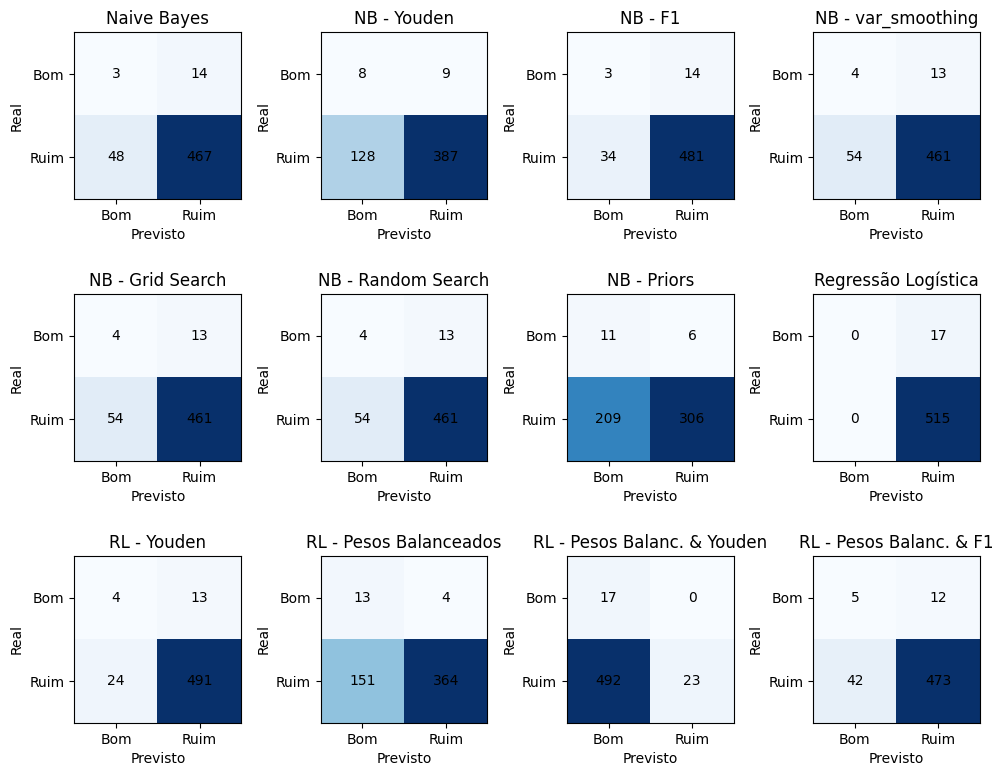

In [46]:
fig, axes = plt.subplots(3, 4, figsize=(10,8))

plot_confusao(axes[0,0], cm_nb, 'Naive Bayes')
plot_confusao(axes[0,1], cm_nb_yj, 'NB - Youden')
plot_confusao(axes[0,2], cm_nb_f1, 'NB - F1')
plot_confusao(axes[0,3], cm_nb_vs, 'NB - var_smoothing')
plot_confusao(axes[1,0], cm_nb_vs_grid, 'NB - Grid Search')
plot_confusao(axes[1,1], cm_nb_vs_random, 'NB - Random Search')
plot_confusao(axes[1,2], cm_nb_priors, 'NB - Priors')
plot_confusao(axes[1,3], cm_log, 'Regressão Logística')
plot_confusao(axes[2,0], cm_log_yj, 'RL - Youden')
plot_confusao(axes[2,1], cm_log_eq, 'RL - Pesos Balanceados')
plot_confusao(axes[2,2], cm_log_eq_yj, 'RL - Pesos Balanc. & Youden')
plot_confusao(axes[2,3], cm_log_eq_f1, 'RL - Pesos Balanc. & F1')

plt.tight_layout()
plt.show()

Os modelos têm muita dificuldade em classificar corretamente os vinhos, uma consequência do grande desbalanceamento entre valores de qualidade boa e ruim. Isso também é resultado do baixo poder explicativo das variáveis, analisado na regressão linear.